# Fatigue Detection Methods

## 1. Direct Method

This method is directly based on the result of facial landmarks dectection. Firstly, we calculate the EAR(Eye Aspected Ratio)for both eyes, if the value is smaller than 0.15, the eye can be considered as closed. Then we calculate the MAR(Mouth Aspected Ratio), if the value is bigger than 0.1, the mouth can be considered as yawn. If the eyes are closed and the mouth is open(yawn), we roughly judge it as fatigue.
Lastly, we evaluate the accuracy of this method on a test set. In this test set, there are three filefolders named as "Eyeclose", "Neutral" and "Yawn". We label the folders "Eyeclose" and "Yawn" as "Yes", which means fatigue, and the other folder as "No". These images in the test set are processed using the fatigue detection method described above, fatigue detection is given to each image and based on the results the results are compared with the actual labels and finally the accuracy of the whole process is calculated.

In [ ]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# Initialize dlib's face detector and face flag detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
# Calculate EAR and MAR
#if EAR <=0.15, eyeclosed; otherwise, false
#if MAR >=0.1, yawn; otherwise, false


def EAR_cpt(eye_LM):
    # Calculate the vertical distance
    v1 = np.linalg.norm(eye_LM[1] - eye_LM[5])
    v2 = np.linalg.norm(eye_LM[2] - eye_LM[4])
    vertical_dist = (v1 + v2) * 0.5

    # Calculated horizontal distance
    horizontal_dist = np.linalg.norm(eye_LM[0] - eye_LM[3])

    ear = vertical_dist / horizontal_dist

    return ear

def MAR_cpt(mouth_LM):
    # Calculate the vertical distance
    v_dist_top = np.linalg.norm(mouth_LM[13] - mouth_LM[19])
    v_dist_bottom = np.linalg.norm(mouth_LM[14] - mouth_LM[18])
    vertical_dist = (v_dist_top + v_dist_bottom) / 2.0

    # Calculated horizontal distance
    horizontal_dist = np.linalg.norm(mouth_LM[12] - mouth_LM[16])

    mar = vertical_dist / horizontal_dist

    return mar

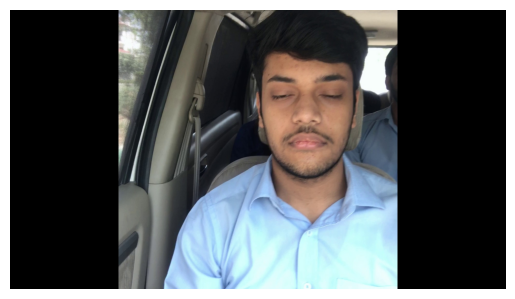

In [ ]:
# Load the pictures
image_path = "361.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect the face
faces = detector(gray, 0)

# Store the EAR and MAR values for each face
ears = []
mars = []

# Use matplotlib to display images
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off') # Do not show axes
plt.show()

In [ ]:
# Iterate over each face detected
for face in faces:
    shape = predictor(gray, face)
    shape_np = np.zeros((68, 2), dtype="int")
    for i in range(0, 68):
        shape_np[i] = (shape.part(i).x, shape.part(i).y)

    # Extract coordinates of eye and mouth
    leftEye = shape_np[42:48]
    rightEye = shape_np[36:42]
    mouth = shape_np[48:68]

    # Calculate EAR and MAR
    leftEAR = EAR_cpt(leftEye)
    rightEAR = EAR_cpt(rightEye)
    ear = (leftEAR + rightEAR) / 2.0
    mar = MAR_cpt(mouth)

    # Store EAR and MAR values
    ears.append(ear)
    mars.append(mar)

    # Determine if fatigued
    drowsiness_detected = "Yes" if ear < 0.15 or mar > 0.1 else "No"
    print(f"Drowsiness Detected: {drowsiness_detected}, EAR: {ear:.4f}, MAR: {mar:.4f}")

Drowsiness Detected: Yes, EAR: 0.0927, MAR: 0.0041


In [ ]:
# Prepare folders and labels
base_dir = "/Users/wangyaojie/Desktop/CV-3D-Project-main/code/test"  # path to the folder of "test"
folders = ["Eyeclose", "Neutral", "Yawn"]
labels = {"Eyeclose": "Yes", "Neutral": "No", "Yawn": "Yes"}

# Store labels and test results
true_labels = []
predicted_labels = []

In [ ]:
# Iterate through each folder and picture
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            true_labels.append(labels[folder])

            # Reading and processing images
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray, 0)

            # Initialize fatigue detection as "No"
            drowsiness_detected = "No"
            for face in faces:
                shape = predictor(gray, face)
                shape_np = np.zeros((68, 2), dtype="int")
                for i in range(68):
                    shape_np[i] = (shape.part(i).x, shape.part(i).y)

                leftEye = shape_np[42:48]
                rightEye = shape_np[36:42]
                mouth = shape_np[48:68]

                ear = (EAR_cpt(leftEye) + EAR_cpt(rightEye)) / 2.0
                mar = MAR_cpt(mouth)

                if ear < 0.15 or mar > 0.1:
                    drowsiness_detected = "Yes"
                    break

            predicted_labels.append(drowsiness_detected)

# Calculation accuracy of this method
accuracy = sum(1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted) / len(true_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9764


## 2. Yolov8

The second method is to use yolov8 to train a specific model. First split our dataset into train and validation datasets, and store them under the corresponding folder. Second, set the training parameters and train the pretrained model. We also plot line graphs of train loss and accuracy values, and validation loss values. Last, perform image classification on our test dataset, and evaluate the model with Accuracy, Precision, Recall and F1 score.

In [14]:
!pip install ultralytics

In [15]:
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Train the model

In [ ]:
# Split the dataset into train and validation datasets first, then store them under the corresponding folder.
def prepare_datasets(src_folder, dst_folder):
    train_dir = os.path.join(dst_folder, 'train')
    val_dir = os.path.join(dst_folder, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    classes = ['Drowsy', 'Non Drowsy']
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        class_dir = os.path.join(src_folder, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        train_data, val_data = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_data:
            shutil.copy(img, os.path.join(train_dir, cls, os.path.basename(img)))
        for img in val_data:
            shutil.copy(img, os.path.join(val_dir, cls, os.path.basename(img)))

In [ ]:
# train the model
def train(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train the model
    model.train(data='../images',
                epochs=50,
                patience=25,
                imgsz=256,
                batch=32,
                save=True,
                save_period=10,
                device=device,
                optimizer='Adam')

In [17]:
# A method to plot line graphs
def plot(data, metrics, label):
    folder_path = 'img'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['epoch'], data[metrics], color='blue')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.grid(True)
    fig.savefig('img/' + label + '.png')
    plt.show()

In [ ]:
# split dataset
source_data_folder = '../images/train1'
destination_folder = '../images'
prepare_datasets(source_data_folder, destination_folder)

# train model
yolov8n = YOLO('yolov8n-cls.pt')
train(yolov8n)

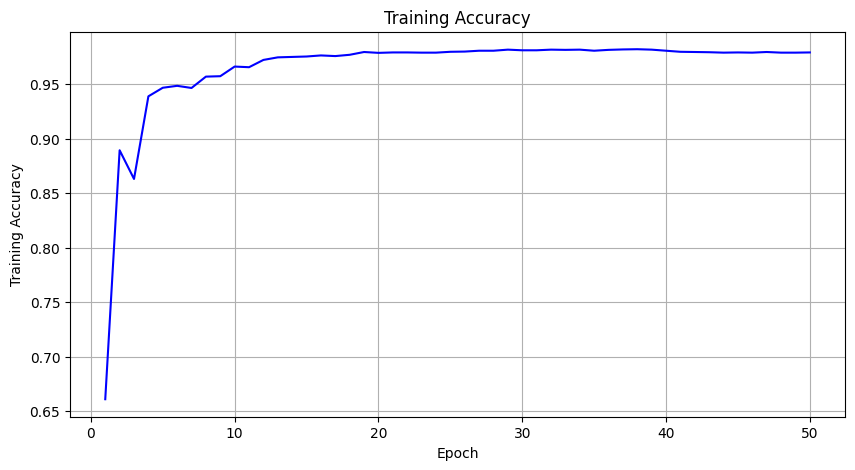

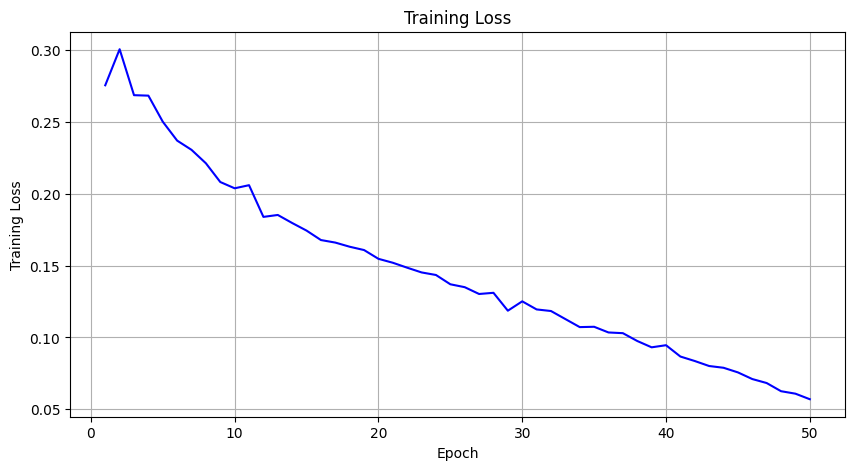

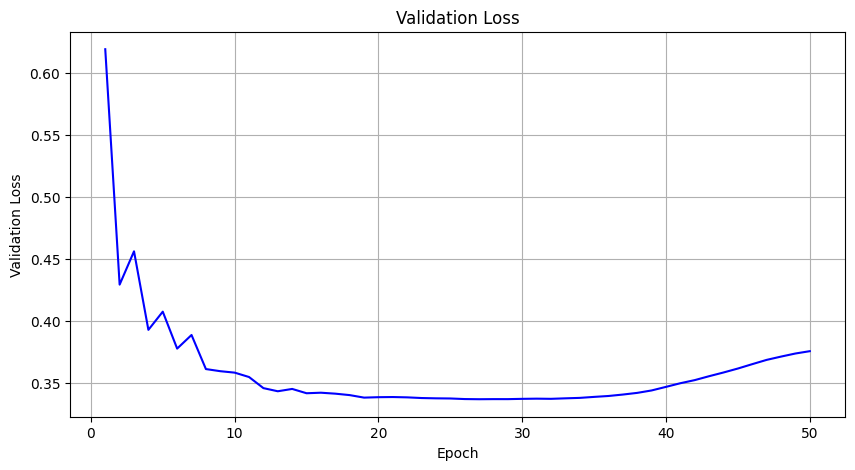

In [18]:
# plot line graphs of training loss values, accuracy values and validation loss values.
current_path = '/content/drive/MyDrive/Colab Notebooks/CV3D/yolov8/'
results = pd.read_csv(current_path + 'runs/classify/train/results.csv')
results.columns = results.columns.str.strip()
plot(results, 'metrics/accuracy_top1', 'Training Accuracy')
plot(results, 'train/loss', 'Training Loss')
plot(results, 'val/loss', 'Validation Loss')

### 2.2 Evaluate on test dataset.

In [23]:
# perform image classification on the test dataset
def test_img(file_pathname, model, name_dict, save_folder):
    file_dir = os.listdir(file_pathname)

    # create new folders for storing the categorized images.
    for k, v in name_dict.items():
        name_folder = os.path.join(save_folder, v)
        if not os.path.exists(name_folder):
            os.makedirs(name_folder)

    # we assume that Drowsy is positive sample and Non Drowsy is negative sample.
    TP_cur, TN_cur, FP_cur, FN_cur = 0, 0, 0, 0
    for filename in tqdm(file_dir):
        img = cv2.imread(file_pathname + '/' + filename)
        results = model.predict(img)

        for result in results:
            name_dict = result.names
            probs = result.probs.cpu().numpy()
            top1_index = result.probs.top1
            labels_and_probs = {
                name_dict[0]: probs.data[0],
                name_dict[1]: probs.data[1]
            }

            class_name = name_dict[top1_index]

            # save the labels and probs on the image
            x, y = 10, 30
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            color = (255, 255, 255)
            thickness = 2

            for label, prob in labels_and_probs.items():
                text = f'{label}: {prob:.5f}'
                cv2.putText(img, text, (x, y), font, font_scale, color, thickness)
                y += 30

            save_img_path = os.path.join(save_folder, class_name, filename)
            cv2.imwrite(save_img_path, img)

            # count TP, TN, FP, FN.
            if file_pathname == current_path+'test/Neutral':
                if class_name == 'Non Drowsy':
                    TN_cur += 1
                else:
                    FP_cur += 1
            else:
                if class_name == 'Drowsy':
                    TP_cur += 1
                else:
                    FN_cur += 1

    return TP_cur, TN_cur, FP_cur, FN_cur

In [24]:
test_folder = ['test/Eyeclose', 'test/Neutral', 'test/Yawn']

name_dict = {0: 'Drowsy', 1: 'Non Drowsy'}
save_folder = current_path + 'runs/classify/predict'
model = YOLO(current_path + 'runs/classify/train/weights/best.pt')

TP, TN, FP, FN = 0, 0, 0, 0
for img_folder in test_folder:
    TP1, TN1, FP1, FN1 = test_img(current_path+img_folder, model, name_dict, save_folder)
    TP += TP1
    TN += TN1
    FP += FP1
    FN += FN1

# metrics
accuracy = (TP + TN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = 2 * TP / (2 * TP + FP + FN)

print("Accuracy: ", accuracy)       # Accuracy:  0.8766404199475065
print("Precision: ", precision)     # Precision:  0.9468085106382979
print("Recall: ", recall)           # Recall:  0.827906976744186
print("F1: ", F1)                   # F1:  0.8833746898263027

  0%|          | 0/157 [00:00<?, ?it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 33.4ms
Speed: 36.2ms preprocess, 33.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  1%|          | 1/157 [00:01<03:37,  1.40s/it]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 39.4ms
Speed: 41.7ms preprocess, 39.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  1%|▏         | 2/157 [00:01<01:46,  1.45it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 24.8ms
Speed: 31.9ms preprocess, 24.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  2%|▏         | 3/157 [00:01<01:25,  1.80it/s]


0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 19.8ms
Speed: 25.7ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.7ms
Speed: 25.3ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  3%|▎         | 5/157 [00:02<00:44,  3.41it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 18.4ms
Speed: 21.9ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 19.5ms
Speed: 21.9ms preprocess, 19.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  4%|▍         | 7/157 [00:02<00:29,  5.00it/s]


0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 19.2ms
Speed: 21.5ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 18.9ms
Speed: 20.3ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  6%|▌         | 9/157 [00:02<00:22,  6.51it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.2ms
Speed: 23.9ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 19.1ms
Speed: 20.8ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  7%|▋         | 11/157 [00:02<00:18,  7.76it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 22.2ms
Speed: 21.0ms preprocess, 22.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 20.0ms
Speed: 22.2ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  8%|▊         | 13/157 [00:02<00:16,  8.71it/s]


0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 19.2ms
Speed: 21.0ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 34.3ms
Speed: 45.5ms preprocess, 34.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 10%|▉         | 15/157 [00:03<00:15,  8.90it/s]


0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 30.5ms
Speed: 36.2ms preprocess, 30.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 34.9ms
Speed: 32.4ms preprocess, 34.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 11%|█         | 17/157 [00:03<00:16,  8.41it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 29.6ms
Speed: 33.8ms preprocess, 29.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 11%|█▏        | 18/157 [00:03<00:16,  8.25it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 30.4ms
Speed: 33.8ms preprocess, 30.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 12%|█▏        | 19/157 [00:03<00:16,  8.17it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 28.4ms
Speed: 32.5ms preprocess, 28.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 13%|█▎        | 20/157 [00:03<00:16,  8.09it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 30.7ms
Speed: 37.3ms preprocess, 30.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 13%|█▎        | 21/157 [00:03<00:17,  7.88it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 30.7ms
Speed: 31.3ms preprocess, 30.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 14%|█▍        | 22/157 [00:03<00:17,  7.78it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 30.8ms
Speed: 33.7ms preprocess, 30.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 15%|█▍        | 23/157 [00:04<00:17,  7.58it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 29.1ms
Speed: 31.6ms preprocess, 29.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 15%|█▌        | 24/157 [00:04<00:17,  7.55it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 28.4ms
Speed: 29.6ms preprocess, 28.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▌        | 25/157 [00:04<00:17,  7.65it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 34.9ms
Speed: 33.2ms preprocess, 34.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 17%|█▋        | 26/157 [00:04<00:17,  7.51it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 33.4ms
Speed: 31.4ms preprocess, 33.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 17%|█▋        | 27/157 [00:04<00:17,  7.42it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 33.8ms
Speed: 31.4ms preprocess, 33.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 18%|█▊        | 28/157 [00:04<00:17,  7.50it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 27.8ms
Speed: 32.9ms preprocess, 27.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 18%|█▊        | 29/157 [00:04<00:16,  7.53it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 32.6ms
Speed: 30.9ms preprocess, 32.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 19%|█▉        | 30/157 [00:05<00:17,  7.39it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 38.4ms
Speed: 44.3ms preprocess, 38.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 20%|█▉        | 31/157 [00:05<00:17,  7.06it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 29.4ms
Speed: 30.7ms preprocess, 29.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 20%|██        | 32/157 [00:05<00:16,  7.39it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 32.5ms
Speed: 31.7ms preprocess, 32.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 21%|██        | 33/157 [00:05<00:16,  7.54it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 31.3ms
Speed: 34.8ms preprocess, 31.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 22%|██▏       | 34/157 [00:05<00:16,  7.45it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 31.8ms
Speed: 29.3ms preprocess, 31.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 22%|██▏       | 35/157 [00:05<00:16,  7.52it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 28.8ms
Speed: 31.9ms preprocess, 28.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 23%|██▎       | 36/157 [00:05<00:15,  7.59it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 30.5ms
Speed: 32.4ms preprocess, 30.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▎       | 37/157 [00:06<00:16,  7.10it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 30.8ms
Speed: 31.0ms preprocess, 30.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▍       | 38/157 [00:06<00:16,  7.30it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 32.3ms
Speed: 38.5ms preprocess, 32.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 25%|██▍       | 39/157 [00:06<00:16,  7.18it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 31.2ms
Speed: 32.7ms preprocess, 31.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 25%|██▌       | 40/157 [00:06<00:15,  7.37it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 28.7ms
Speed: 32.1ms preprocess, 28.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 26%|██▌       | 41/157 [00:06<00:15,  7.45it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 30.1ms
Speed: 34.4ms preprocess, 30.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 27%|██▋       | 42/157 [00:06<00:15,  7.49it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 32.5ms
Speed: 36.0ms preprocess, 32.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 27%|██▋       | 43/157 [00:06<00:15,  7.41it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 31.4ms
Speed: 30.0ms preprocess, 31.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 28%|██▊       | 44/157 [00:06<00:14,  7.58it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 32.1ms
Speed: 31.2ms preprocess, 32.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 29%|██▊       | 45/157 [00:07<00:14,  7.67it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 33.3ms
Speed: 35.9ms preprocess, 33.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 29%|██▉       | 46/157 [00:07<00:14,  7.50it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 22.4ms
Speed: 33.5ms preprocess, 22.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 30%|██▉       | 47/157 [00:07<00:14,  7.60it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.2ms
Speed: 20.9ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.85, Non Drowsy 0.15, 20.7ms
Speed: 21.2ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 31%|███       | 49/157 [00:07<00:11,  9.03it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 19.2ms
Speed: 21.8ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 18.9ms
Speed: 21.8ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 32%|███▏      | 51/157 [00:07<00:10,  9.96it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.1ms
Speed: 21.6ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 19.7ms
Speed: 21.3ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 34%|███▍      | 53/157 [00:07<00:09, 10.50it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.7ms
Speed: 21.8ms preprocess, 21.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.5ms
Speed: 23.5ms preprocess, 19.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 35%|███▌      | 55/157 [00:08<00:09, 10.91it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 20.0ms
Speed: 22.0ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 20.4ms
Speed: 21.6ms preprocess, 20.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 36%|███▋      | 57/157 [00:08<00:09, 11.08it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 18.6ms
Speed: 22.4ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 20.8ms
Speed: 24.2ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 38%|███▊      | 59/157 [00:08<00:09, 10.86it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 20.7ms
Speed: 22.1ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 19.1ms
Speed: 21.8ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 39%|███▉      | 61/157 [00:08<00:08, 10.96it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.0ms
Speed: 23.8ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.0ms
Speed: 24.1ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 40%|████      | 63/157 [00:08<00:08, 11.08it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 18.6ms
Speed: 22.2ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.2ms
Speed: 24.8ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 41%|████▏     | 65/157 [00:08<00:08, 11.17it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 22.0ms
Speed: 21.6ms preprocess, 22.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.3ms
Speed: 20.7ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 43%|████▎     | 67/157 [00:09<00:07, 11.30it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.3ms
Speed: 22.0ms preprocess, 21.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 20.7ms
Speed: 21.4ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 44%|████▍     | 69/157 [00:09<00:07, 11.28it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 23.6ms
Speed: 23.1ms preprocess, 23.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 18.6ms
Speed: 23.6ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 45%|████▌     | 71/157 [00:09<00:07, 11.02it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.9ms
Speed: 22.9ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.8ms
Speed: 23.8ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 46%|████▋     | 73/157 [00:09<00:07, 11.05it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 21.4ms
Speed: 21.5ms preprocess, 21.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 25.8ms
Speed: 20.9ms preprocess, 25.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 48%|████▊     | 75/157 [00:09<00:07, 11.11it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 20.5ms
Speed: 23.6ms preprocess, 20.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.8ms
Speed: 25.0ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 49%|████▉     | 77/157 [00:10<00:07, 10.52it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 21.0ms
Speed: 22.3ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 22.2ms
Speed: 22.0ms preprocess, 22.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 50%|█████     | 79/157 [00:10<00:07, 10.66it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.2ms
Speed: 22.3ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 18.7ms
Speed: 22.5ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 52%|█████▏    | 81/157 [00:10<00:06, 10.89it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 22.2ms
Speed: 22.9ms preprocess, 22.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 22.0ms
Speed: 24.4ms preprocess, 22.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 53%|█████▎    | 83/157 [00:10<00:07, 10.49it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.7ms
Speed: 23.6ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 26.3ms
Speed: 23.6ms preprocess, 26.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 54%|█████▍    | 85/157 [00:10<00:06, 10.56it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 20.3ms
Speed: 23.1ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.3ms
Speed: 21.9ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 55%|█████▌    | 87/157 [00:10<00:06, 10.69it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.9ms
Speed: 21.9ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.6ms
Speed: 22.6ms preprocess, 21.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 57%|█████▋    | 89/157 [00:11<00:06, 10.89it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 18.7ms
Speed: 21.2ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 19.3ms
Speed: 20.7ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 58%|█████▊    | 91/157 [00:11<00:05, 11.14it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 20.9ms
Speed: 21.0ms preprocess, 20.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 28.1ms
Speed: 33.4ms preprocess, 28.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 59%|█████▉    | 93/157 [00:11<00:05, 10.96it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 18.7ms
Speed: 25.5ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 18.7ms
Speed: 21.3ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 61%|██████    | 95/157 [00:11<00:05, 11.12it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.1ms
Speed: 23.0ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.6ms
Speed: 22.5ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 62%|██████▏   | 97/157 [00:11<00:05, 11.18it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 21.8ms
Speed: 21.7ms preprocess, 21.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.0ms
Speed: 21.1ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 63%|██████▎   | 99/157 [00:12<00:05, 11.26it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 20.0ms
Speed: 20.7ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 19.5ms
Speed: 22.3ms preprocess, 19.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 64%|██████▍   | 101/157 [00:12<00:04, 11.35it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 21.0ms
Speed: 27.4ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.8ms
Speed: 22.3ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 66%|██████▌   | 103/157 [00:12<00:04, 11.27it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 20.2ms
Speed: 22.7ms preprocess, 20.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 21.2ms
Speed: 22.7ms preprocess, 21.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 67%|██████▋   | 105/157 [00:12<00:04, 11.13it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 20.9ms
Speed: 23.7ms preprocess, 20.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 21.1ms
Speed: 22.0ms preprocess, 21.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 68%|██████▊   | 107/157 [00:12<00:04, 11.22it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.0ms
Speed: 20.9ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 20.0ms
Speed: 24.2ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 69%|██████▉   | 109/157 [00:12<00:04, 11.40it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.9ms
Speed: 22.0ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 19.8ms
Speed: 21.6ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 71%|███████   | 111/157 [00:13<00:04, 11.39it/s]


0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 21.7ms
Speed: 22.2ms preprocess, 21.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.98, Non Drowsy 0.02, 21.5ms
Speed: 21.9ms preprocess, 21.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 72%|███████▏  | 113/157 [00:13<00:03, 11.25it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 18.5ms
Speed: 21.9ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 20.1ms
Speed: 22.2ms preprocess, 20.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 73%|███████▎  | 115/157 [00:13<00:03, 11.39it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 21.2ms
Speed: 25.0ms preprocess, 21.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 19.8ms
Speed: 21.8ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 75%|███████▍  | 117/157 [00:13<00:03, 10.79it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 19.9ms
Speed: 21.3ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 20.6ms
Speed: 28.2ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 76%|███████▌  | 119/157 [00:13<00:03, 10.84it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.0ms
Speed: 21.0ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 19.1ms
Speed: 21.2ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 77%|███████▋  | 121/157 [00:14<00:03, 11.16it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 20.8ms
Speed: 22.0ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.7ms
Speed: 22.6ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 78%|███████▊  | 123/157 [00:14<00:03, 11.26it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 20.6ms
Speed: 23.5ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 19.3ms
Speed: 23.2ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 80%|███████▉  | 125/157 [00:14<00:02, 11.25it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.1ms
Speed: 25.2ms preprocess, 21.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.3ms
Speed: 22.2ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 81%|████████  | 127/157 [00:14<00:02, 11.24it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 18.9ms
Speed: 24.5ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 23.9ms
Speed: 23.0ms preprocess, 23.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 82%|████████▏ | 129/157 [00:14<00:02, 10.99it/s]


0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 20.8ms
Speed: 23.7ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.7ms
Speed: 21.6ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 83%|████████▎ | 131/157 [00:14<00:02, 11.09it/s]


0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 18.5ms
Speed: 22.2ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 20.7ms
Speed: 23.2ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 85%|████████▍ | 133/157 [00:15<00:02, 11.16it/s]


0: 256x256 Drowsy 0.87, Non Drowsy 0.13, 20.9ms
Speed: 23.5ms preprocess, 20.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.9ms
Speed: 21.5ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 86%|████████▌ | 135/157 [00:15<00:01, 11.10it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 21.9ms
Speed: 21.4ms preprocess, 21.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 20.3ms
Speed: 21.6ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 87%|████████▋ | 137/157 [00:15<00:01, 11.18it/s]


0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 18.9ms
Speed: 23.3ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 27.6ms
Speed: 21.2ms preprocess, 27.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 89%|████████▊ | 139/157 [00:15<00:01, 11.12it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 25.1ms
Speed: 23.1ms preprocess, 25.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.88, Non Drowsy 0.12, 19.2ms
Speed: 21.3ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 90%|████████▉ | 141/157 [00:15<00:01, 11.01it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 18.2ms
Speed: 21.0ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.3ms
Speed: 23.4ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 91%|█████████ | 143/157 [00:15<00:01, 11.19it/s]


0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 18.8ms
Speed: 22.5ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 19.7ms
Speed: 21.5ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 92%|█████████▏| 145/157 [00:16<00:01, 11.28it/s]


0: 256x256 Drowsy 0.94, Non Drowsy 0.06, 18.5ms
Speed: 21.3ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 21.4ms
Speed: 23.2ms preprocess, 21.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 94%|█████████▎| 147/157 [00:16<00:00, 11.40it/s]


0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 22.1ms
Speed: 21.2ms preprocess, 22.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.9ms
Speed: 21.5ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 95%|█████████▍| 149/157 [00:16<00:00, 11.39it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 27.8ms
Speed: 23.5ms preprocess, 27.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 41.4ms
Speed: 84.2ms preprocess, 41.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 96%|█████████▌| 151/157 [00:16<00:00,  9.09it/s]


0: 256x256 Drowsy 0.92, Non Drowsy 0.08, 19.5ms
Speed: 23.8ms preprocess, 19.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 20.1ms
Speed: 21.9ms preprocess, 20.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 97%|█████████▋| 153/157 [00:17<00:00,  9.60it/s]


0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 18.6ms
Speed: 21.5ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 19.6ms
Speed: 21.7ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 99%|█████████▊| 155/157 [00:17<00:00, 10.15it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.5ms
Speed: 23.5ms preprocess, 19.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 141.8ms
Speed: 53.5ms preprocess, 141.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  0%|          | 0/166 [00:00<?, ?it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 33.9ms
Speed: 31.0ms preprocess, 33.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  1%|          | 1/166 [00:00<00:30,  5.45it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.7ms
Speed: 35.3ms preprocess, 29.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  1%|          | 2/166 [00:00<01:06,  2.46it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 29.9ms
Speed: 31.5ms preprocess, 29.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  2%|▏         | 3/166 [00:00<00:45,  3.56it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 30.8ms
Speed: 32.7ms preprocess, 30.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  2%|▏         | 4/166 [00:01<00:36,  4.47it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 32.7ms
Speed: 29.6ms preprocess, 32.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  3%|▎         | 5/166 [00:01<00:31,  5.17it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 34.5ms
Speed: 32.0ms preprocess, 34.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  4%|▎         | 6/166 [00:01<00:27,  5.81it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 32.0ms
Speed: 30.4ms preprocess, 32.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  4%|▍         | 7/166 [00:01<00:25,  6.32it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 33.3ms
Speed: 38.9ms preprocess, 33.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  5%|▍         | 8/166 [00:01<00:24,  6.55it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 32.4ms
Speed: 33.8ms preprocess, 32.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  5%|▌         | 9/166 [00:01<00:23,  6.76it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 30.1ms
Speed: 34.0ms preprocess, 30.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  6%|▌         | 10/166 [00:01<00:22,  7.02it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.1ms
Speed: 32.4ms preprocess, 29.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  7%|▋         | 11/166 [00:01<00:21,  7.23it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.0ms
Speed: 31.7ms preprocess, 29.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  7%|▋         | 12/166 [00:02<00:20,  7.34it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.0ms
Speed: 32.3ms preprocess, 29.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  8%|▊         | 13/166 [00:02<00:20,  7.46it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.2ms
Speed: 34.5ms preprocess, 29.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  8%|▊         | 14/166 [00:02<00:20,  7.37it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.1ms
Speed: 39.7ms preprocess, 29.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  9%|▉         | 15/166 [00:02<00:20,  7.44it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.2ms
Speed: 29.8ms preprocess, 28.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 10%|▉         | 16/166 [00:02<00:19,  7.72it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 30.7ms
Speed: 29.6ms preprocess, 30.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 10%|█         | 17/166 [00:02<00:18,  7.93it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 30.6ms
Speed: 30.9ms preprocess, 30.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 11%|█         | 18/166 [00:02<00:18,  8.08it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.4ms
Speed: 29.4ms preprocess, 29.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 11%|█▏        | 19/166 [00:02<00:17,  8.22it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 28.9ms
Speed: 29.7ms preprocess, 28.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 12%|█▏        | 20/166 [00:03<00:17,  8.33it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 30.8ms
Speed: 30.0ms preprocess, 30.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 13%|█▎        | 21/166 [00:03<00:17,  8.38it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 41.7ms
Speed: 29.9ms preprocess, 41.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 13%|█▎        | 22/166 [00:03<00:18,  7.99it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 29.0ms
Speed: 31.3ms preprocess, 29.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 14%|█▍        | 23/166 [00:03<00:18,  7.92it/s]


0: 256x256 Non Drowsy 0.66, Drowsy 0.34, 28.2ms
Speed: 35.5ms preprocess, 28.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 14%|█▍        | 24/166 [00:03<00:17,  7.93it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 31.6ms
Speed: 33.3ms preprocess, 31.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 15%|█▌        | 25/166 [00:03<00:18,  7.79it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 30.3ms
Speed: 30.7ms preprocess, 30.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▌        | 26/166 [00:03<00:18,  7.77it/s]


0: 256x256 Non Drowsy 0.72, Drowsy 0.28, 29.4ms
Speed: 33.8ms preprocess, 29.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▋        | 27/166 [00:03<00:18,  7.62it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 31.7ms
Speed: 33.5ms preprocess, 31.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 17%|█▋        | 28/166 [00:04<00:18,  7.50it/s]


0: 256x256 Non Drowsy 0.97, Drowsy 0.03, 29.8ms
Speed: 33.2ms preprocess, 29.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 17%|█▋        | 29/166 [00:04<00:18,  7.50it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 24.5ms
Speed: 24.8ms preprocess, 24.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 18%|█▊        | 30/166 [00:04<00:16,  8.01it/s]


0: 256x256 Drowsy 0.93, Non Drowsy 0.07, 19.9ms
Speed: 21.9ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.6ms
Speed: 22.4ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 19%|█▉        | 32/166 [00:04<00:14,  9.20it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.2ms
Speed: 23.6ms preprocess, 20.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 23.2ms
Speed: 21.6ms preprocess, 23.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 20%|██        | 34/166 [00:04<00:13,  9.89it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.5ms
Speed: 22.0ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.6ms
Speed: 22.6ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 22%|██▏       | 36/166 [00:04<00:13,  9.90it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.6ms
Speed: 24.2ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.4ms
Speed: 22.0ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 23%|██▎       | 38/166 [00:05<00:12, 10.33it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 23.9ms
Speed: 21.5ms preprocess, 23.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.4ms
Speed: 22.5ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▍       | 40/166 [00:05<00:11, 10.63it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.1ms
Speed: 21.7ms preprocess, 18.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.4ms
Speed: 21.0ms preprocess, 20.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 25%|██▌       | 42/166 [00:05<00:11, 10.79it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.0ms
Speed: 22.1ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.3ms
Speed: 20.5ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 27%|██▋       | 44/166 [00:05<00:11, 10.99it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.0ms
Speed: 21.2ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.6ms
Speed: 22.3ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 28%|██▊       | 46/166 [00:05<00:10, 11.23it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 21.1ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.4ms
Speed: 20.3ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 29%|██▉       | 48/166 [00:05<00:10, 11.22it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 21.5ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.91, Non Drowsy 0.09, 19.0ms
Speed: 26.1ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 30%|███       | 50/166 [00:06<00:10, 11.30it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.6ms
Speed: 22.6ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 21.0ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 31%|███▏      | 52/166 [00:06<00:10, 11.30it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 25.3ms
Speed: 22.6ms preprocess, 25.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.6ms
Speed: 23.7ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 33%|███▎      | 54/166 [00:06<00:10, 11.08it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.9ms
Speed: 21.6ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 17.8ms
Speed: 23.3ms preprocess, 17.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 34%|███▎      | 56/166 [00:06<00:09, 11.17it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.4ms
Speed: 22.9ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.4ms
Speed: 21.1ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 35%|███▍      | 58/166 [00:06<00:09, 11.33it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 24.1ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 20.8ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 36%|███▌      | 60/166 [00:07<00:09, 11.50it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 21.9ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.8ms
Speed: 26.4ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 37%|███▋      | 62/166 [00:07<00:09, 11.50it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.6ms
Speed: 21.0ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.0ms
Speed: 20.8ms preprocess, 18.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 39%|███▊      | 64/166 [00:07<00:08, 11.52it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.1ms
Speed: 21.0ms preprocess, 29.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 22.9ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 40%|███▉      | 66/166 [00:07<00:08, 11.29it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 21.9ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.7ms
Speed: 23.5ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 41%|████      | 68/166 [00:07<00:08, 11.33it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.4ms
Speed: 21.1ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 17.9ms
Speed: 21.6ms preprocess, 17.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 42%|████▏     | 70/166 [00:07<00:08, 11.46it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.7ms
Speed: 20.9ms preprocess, 19.7ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.1ms
Speed: 21.7ms preprocess, 18.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 43%|████▎     | 72/166 [00:08<00:08, 11.58it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 21.7ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.0ms
Speed: 21.8ms preprocess, 18.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 45%|████▍     | 74/166 [00:08<00:07, 11.73it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 18.2ms
Speed: 24.7ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.3ms
Speed: 21.1ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 46%|████▌     | 76/166 [00:08<00:07, 11.38it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.6ms
Speed: 31.2ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 21.4ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 47%|████▋     | 78/166 [00:08<00:07, 11.23it/s]


0: 256x256 Drowsy 0.97, Non Drowsy 0.03, 19.7ms
Speed: 22.1ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 18.1ms
Speed: 21.2ms preprocess, 18.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 48%|████▊     | 80/166 [00:08<00:07, 11.29it/s]


0: 256x256 Drowsy 0.90, Non Drowsy 0.10, 18.5ms
Speed: 21.3ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 21.3ms
Speed: 22.3ms preprocess, 21.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 49%|████▉     | 82/166 [00:08<00:07, 11.42it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 20.2ms
Speed: 21.2ms preprocess, 20.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.96, Non Drowsy 0.04, 18.3ms
Speed: 21.2ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 51%|█████     | 84/166 [00:09<00:07, 11.53it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 21.9ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 23.8ms
Speed: 20.9ms preprocess, 23.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 52%|█████▏    | 86/166 [00:09<00:06, 11.56it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 18.3ms
Speed: 22.3ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.6ms
Speed: 23.9ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 53%|█████▎    | 88/166 [00:09<00:06, 11.50it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.4ms
Speed: 25.5ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.90, Drowsy 0.10, 20.1ms
Speed: 21.6ms preprocess, 20.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 54%|█████▍    | 90/166 [00:09<00:06, 11.21it/s]


0: 256x256 Drowsy 0.78, Non Drowsy 0.22, 21.4ms
Speed: 24.2ms preprocess, 21.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 19.0ms
Speed: 21.8ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 55%|█████▌    | 92/166 [00:09<00:06, 11.22it/s]


0: 256x256 Drowsy 0.95, Non Drowsy 0.05, 22.9ms
Speed: 23.5ms preprocess, 22.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.70, Non Drowsy 0.30, 19.6ms
Speed: 23.6ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 57%|█████▋    | 94/166 [00:10<00:06, 11.15it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 18.9ms
Speed: 22.9ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 28.0ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 58%|█████▊    | 96/166 [00:10<00:06, 11.01it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 23.0ms
Speed: 24.2ms preprocess, 23.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 23.2ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 59%|█████▉    | 98/166 [00:10<00:06, 11.08it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.5ms
Speed: 24.7ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.3ms
Speed: 21.5ms preprocess, 28.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 60%|██████    | 100/166 [00:10<00:06, 10.94it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 18.4ms
Speed: 21.5ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 22.2ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 61%|██████▏   | 102/166 [00:10<00:05, 11.10it/s]


0: 256x256 Non Drowsy 0.88, Drowsy 0.12, 18.6ms
Speed: 21.0ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 22.2ms
Speed: 21.6ms preprocess, 22.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 63%|██████▎   | 104/166 [00:10<00:05, 11.23it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 21.2ms
Speed: 23.1ms preprocess, 21.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.0ms
Speed: 21.7ms preprocess, 18.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 64%|██████▍   | 106/166 [00:11<00:05, 11.25it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 22.9ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.5ms
Speed: 21.0ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 65%|██████▌   | 108/166 [00:11<00:05, 11.43it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 22.6ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.5ms
Speed: 21.6ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 66%|██████▋   | 110/166 [00:11<00:04, 11.38it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 22.0ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 31.7ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 67%|██████▋   | 112/166 [00:11<00:04, 11.22it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.9ms
Speed: 23.3ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 22.3ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 69%|██████▊   | 114/166 [00:11<00:04, 11.24it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.3ms
Speed: 25.0ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 22.4ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 70%|██████▉   | 116/166 [00:12<00:04, 10.68it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.7ms
Speed: 23.3ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 22.0ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 71%|███████   | 118/166 [00:12<00:04, 10.86it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.6ms
Speed: 21.9ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 21.0ms
Speed: 23.6ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 72%|███████▏  | 120/166 [00:12<00:04, 10.95it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 21.8ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 21.0ms
Speed: 23.9ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 73%|███████▎  | 122/166 [00:12<00:03, 11.06it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 26.8ms
Speed: 25.6ms preprocess, 26.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 22.1ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 75%|███████▍  | 124/166 [00:12<00:03, 10.99it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.3ms
Speed: 22.4ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.1ms
Speed: 21.9ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 76%|███████▌  | 126/166 [00:12<00:03, 11.17it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.3ms
Speed: 21.1ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 23.2ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 77%|███████▋  | 128/166 [00:13<00:03, 11.27it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.8ms
Speed: 22.4ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.9ms
Speed: 21.7ms preprocess, 19.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 78%|███████▊  | 130/166 [00:13<00:03, 11.36it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 26.3ms
Speed: 22.9ms preprocess, 26.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.3ms
Speed: 22.3ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 80%|███████▉  | 132/166 [00:13<00:03, 11.22it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.3ms
Speed: 26.5ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 22.0ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 81%|████████  | 134/166 [00:13<00:02, 11.20it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.4ms
Speed: 21.6ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.7ms
Speed: 23.3ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 82%|████████▏ | 136/166 [00:13<00:02, 10.98it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 22.8ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.2ms
Speed: 25.1ms preprocess, 18.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 83%|████████▎ | 138/166 [00:13<00:02, 11.05it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 19.7ms
Speed: 20.9ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.95, Drowsy 0.05, 19.1ms
Speed: 24.2ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 84%|████████▍ | 140/166 [00:14<00:02, 11.26it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.7ms
Speed: 25.4ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 31.1ms
Speed: 38.8ms preprocess, 31.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 86%|████████▌ | 142/166 [00:14<00:02, 10.75it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 31.6ms
Speed: 34.0ms preprocess, 31.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.6ms
Speed: 30.4ms preprocess, 29.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 87%|████████▋ | 144/166 [00:14<00:02,  9.64it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.6ms
Speed: 41.5ms preprocess, 28.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 87%|████████▋ | 145/166 [00:14<00:02,  9.19it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.4ms
Speed: 34.8ms preprocess, 28.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 88%|████████▊ | 146/166 [00:14<00:02,  8.63it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.9ms
Speed: 33.0ms preprocess, 29.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 89%|████████▊ | 147/166 [00:15<00:02,  8.53it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.5ms
Speed: 31.4ms preprocess, 29.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 89%|████████▉ | 148/166 [00:15<00:02,  8.52it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.7ms
Speed: 31.7ms preprocess, 28.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 90%|████████▉ | 149/166 [00:15<00:01,  8.52it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 33.2ms
Speed: 33.4ms preprocess, 33.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 90%|█████████ | 150/166 [00:15<00:01,  8.33it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 31.9ms
Speed: 29.9ms preprocess, 31.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 91%|█████████ | 151/166 [00:15<00:01,  8.35it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.3ms
Speed: 29.2ms preprocess, 29.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 92%|█████████▏| 152/166 [00:15<00:01,  8.43it/s]


0: 256x256 Drowsy 0.69, Non Drowsy 0.31, 31.3ms
Speed: 29.2ms preprocess, 31.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 92%|█████████▏| 153/166 [00:15<00:01,  8.36it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 27.6ms
Speed: 29.7ms preprocess, 27.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 93%|█████████▎| 154/166 [00:15<00:01,  8.26it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 29.9ms
Speed: 33.6ms preprocess, 29.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 93%|█████████▎| 155/166 [00:16<00:01,  7.64it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 32.9ms
Speed: 35.1ms preprocess, 32.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 94%|█████████▍| 156/166 [00:16<00:01,  7.64it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 32.4ms
Speed: 33.5ms preprocess, 32.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 95%|█████████▍| 157/166 [00:16<00:01,  7.45it/s]


0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 28.8ms
Speed: 34.6ms preprocess, 28.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 95%|█████████▌| 158/166 [00:16<00:01,  7.39it/s]


0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 28.8ms
Speed: 32.6ms preprocess, 28.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 96%|█████████▌| 159/166 [00:16<00:00,  7.52it/s]


0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 29.9ms
Speed: 36.9ms preprocess, 29.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 96%|█████████▋| 160/166 [00:16<00:00,  7.41it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 33.0ms
Speed: 37.6ms preprocess, 33.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 97%|█████████▋| 161/166 [00:16<00:00,  7.18it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 28.7ms
Speed: 106.2ms preprocess, 28.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 98%|█████████▊| 162/166 [00:17<00:00,  5.34it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 28.8ms
Speed: 32.7ms preprocess, 28.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 98%|█████████▊| 163/166 [00:17<00:00,  5.67it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 27.7ms
Speed: 30.2ms preprocess, 27.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 99%|█████████▉| 164/166 [00:17<00:00,  6.25it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 29.0ms
Speed: 32.7ms preprocess, 29.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 99%|█████████▉| 165/166 [00:17<00:00,  6.65it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 30.7ms
Speed: 30.6ms preprocess, 30.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  0%|          | 0/58 [00:00<?, ?it/s]


0: 256x256 Drowsy 0.80, Non Drowsy 0.20, 27.9ms
Speed: 32.2ms preprocess, 27.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  2%|▏         | 1/58 [00:00<00:07,  7.95it/s]


0: 256x256 Drowsy 0.65, Non Drowsy 0.35, 34.2ms
Speed: 31.1ms preprocess, 34.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  3%|▎         | 2/58 [00:00<00:07,  7.65it/s]


0: 256x256 Non Drowsy 0.57, Drowsy 0.43, 28.4ms
Speed: 30.9ms preprocess, 28.4ms inference, 0.3ms postprocess per image at shape (1, 3, 256, 256)


  5%|▌         | 3/58 [00:00<00:07,  7.71it/s]


0: 256x256 Drowsy 0.72, Non Drowsy 0.28, 30.3ms
Speed: 30.0ms preprocess, 30.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  7%|▋         | 4/58 [00:00<00:06,  7.81it/s]


0: 256x256 Drowsy 0.72, Non Drowsy 0.28, 35.2ms
Speed: 35.5ms preprocess, 35.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


  9%|▊         | 5/58 [00:00<00:07,  7.35it/s]


0: 256x256 Drowsy 0.68, Non Drowsy 0.32, 30.8ms
Speed: 30.7ms preprocess, 30.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 10%|█         | 6/58 [00:00<00:07,  7.30it/s]


0: 256x256 Drowsy 0.65, Non Drowsy 0.35, 33.0ms
Speed: 31.5ms preprocess, 33.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 12%|█▏        | 7/58 [00:00<00:06,  7.31it/s]


0: 256x256 Non Drowsy 0.59, Drowsy 0.41, 34.4ms
Speed: 31.9ms preprocess, 34.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 14%|█▍        | 8/58 [00:01<00:06,  7.29it/s]


0: 256x256 Non Drowsy 0.85, Drowsy 0.15, 31.8ms
Speed: 35.1ms preprocess, 31.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 16%|█▌        | 9/58 [00:01<00:06,  7.29it/s]


0: 256x256 Non Drowsy 0.62, Drowsy 0.38, 46.4ms
Speed: 35.9ms preprocess, 46.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 17%|█▋        | 10/58 [00:01<00:06,  7.04it/s]


0: 256x256 Non Drowsy 0.87, Drowsy 0.13, 32.1ms
Speed: 33.7ms preprocess, 32.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 19%|█▉        | 11/58 [00:01<00:06,  7.11it/s]


0: 256x256 Drowsy 0.66, Non Drowsy 0.34, 21.4ms
Speed: 37.5ms preprocess, 21.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 21%|██        | 12/58 [00:01<00:06,  7.39it/s]


0: 256x256 Drowsy 0.54, Non Drowsy 0.46, 19.6ms
Speed: 21.9ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.79, Drowsy 0.21, 18.8ms
Speed: 21.5ms preprocess, 18.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 24%|██▍       | 14/58 [00:01<00:05,  8.74it/s]


0: 256x256 Non Drowsy 0.89, Drowsy 0.11, 20.6ms
Speed: 22.9ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.73, Drowsy 0.27, 19.3ms
Speed: 23.1ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 28%|██▊       | 16/58 [00:01<00:04,  9.49it/s]


0: 256x256 Non Drowsy 0.78, Drowsy 0.22, 25.1ms
Speed: 25.9ms preprocess, 25.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.77, Drowsy 0.23, 21.2ms
Speed: 22.4ms preprocess, 21.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 31%|███       | 18/58 [00:02<00:04,  9.85it/s]


0: 256x256 Non Drowsy 0.52, Drowsy 0.48, 18.7ms
Speed: 22.2ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.88, Drowsy 0.12, 21.0ms
Speed: 21.9ms preprocess, 21.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 34%|███▍      | 20/58 [00:02<00:03, 10.11it/s]


0: 256x256 Non Drowsy 0.58, Drowsy 0.42, 20.6ms
Speed: 22.5ms preprocess, 20.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 36%|███▌      | 21/58 [00:02<00:03, 10.00it/s]


0: 256x256 Non Drowsy 0.69, Drowsy 0.31, 20.9ms
Speed: 22.6ms preprocess, 20.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.77, Drowsy 0.23, 23.5ms
Speed: 23.3ms preprocess, 23.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 40%|███▉      | 23/58 [00:02<00:03, 10.20it/s]


0: 256x256 Non Drowsy 0.82, Drowsy 0.18, 19.4ms
Speed: 23.8ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.76, Non Drowsy 0.24, 19.2ms
Speed: 25.4ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 43%|████▎     | 25/58 [00:02<00:03, 10.48it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.3ms
Speed: 24.5ms preprocess, 19.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.66, Drowsy 0.34, 19.8ms
Speed: 25.1ms preprocess, 19.8ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 47%|████▋     | 27/58 [00:03<00:02, 10.64it/s]


0: 256x256 Non Drowsy 0.72, Drowsy 0.28, 18.6ms
Speed: 22.0ms preprocess, 18.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.62, Non Drowsy 0.38, 20.5ms
Speed: 23.2ms preprocess, 20.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 50%|█████     | 29/58 [00:03<00:02, 10.43it/s]


0: 256x256 Drowsy 0.78, Non Drowsy 0.22, 22.0ms
Speed: 25.7ms preprocess, 22.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.57, Non Drowsy 0.43, 19.4ms
Speed: 22.7ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 53%|█████▎    | 31/58 [00:03<00:02, 10.50it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.9ms
Speed: 22.1ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.4ms
Speed: 23.2ms preprocess, 20.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 57%|█████▋    | 33/58 [00:03<00:02, 10.57it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.5ms
Speed: 21.9ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.2ms
Speed: 22.7ms preprocess, 20.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 60%|██████    | 35/58 [00:03<00:02, 10.69it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 20.1ms
Speed: 24.3ms preprocess, 20.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.72, Non Drowsy 0.28, 18.3ms
Speed: 21.5ms preprocess, 18.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 64%|██████▍   | 37/58 [00:03<00:01, 10.85it/s]


0: 256x256 Drowsy 0.81, Non Drowsy 0.19, 20.3ms
Speed: 24.5ms preprocess, 20.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.61, Non Drowsy 0.39, 18.9ms
Speed: 21.6ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 67%|██████▋   | 39/58 [00:04<00:01, 10.71it/s]


0: 256x256 Drowsy 0.75, Non Drowsy 0.25, 18.7ms
Speed: 24.0ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 24.7ms
Speed: 23.1ms preprocess, 24.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 71%|███████   | 41/58 [00:04<00:01, 10.74it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.2ms
Speed: 23.1ms preprocess, 19.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.1ms
Speed: 26.0ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 74%|███████▍  | 43/58 [00:04<00:01, 10.58it/s]


0: 256x256 Drowsy 0.69, Non Drowsy 0.31, 19.7ms
Speed: 22.4ms preprocess, 19.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.78, Non Drowsy 0.22, 20.7ms
Speed: 22.5ms preprocess, 20.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 78%|███████▊  | 45/58 [00:04<00:01, 10.60it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 18.7ms
Speed: 21.8ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.1ms
Speed: 21.8ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 81%|████████  | 47/58 [00:04<00:01, 10.77it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 18.4ms
Speed: 22.3ms preprocess, 18.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.6ms
Speed: 22.3ms preprocess, 19.6ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 84%|████████▍ | 49/58 [00:05<00:00, 10.90it/s]


0: 256x256 Non Drowsy 0.86, Drowsy 0.14, 18.5ms
Speed: 27.2ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 22.3ms
Speed: 21.4ms preprocess, 22.3ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 88%|████████▊ | 51/58 [00:05<00:00, 10.92it/s]


0: 256x256 Non Drowsy 0.99, Drowsy 0.01, 19.4ms
Speed: 22.5ms preprocess, 19.4ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.98, Drowsy 0.02, 18.9ms
Speed: 23.6ms preprocess, 18.9ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 91%|█████████▏| 53/58 [00:05<00:00, 10.90it/s]


0: 256x256 Non Drowsy 1.00, Drowsy 0.00, 22.2ms
Speed: 32.1ms preprocess, 22.2ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Non Drowsy 0.71, Drowsy 0.29, 19.0ms
Speed: 22.0ms preprocess, 19.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 95%|█████████▍| 55/58 [00:05<00:00, 10.82it/s]


0: 256x256 Drowsy 0.75, Non Drowsy 0.25, 20.0ms
Speed: 24.5ms preprocess, 20.0ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 Drowsy 0.89, Non Drowsy 0.11, 18.5ms
Speed: 22.7ms preprocess, 18.5ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


 98%|█████████▊| 57/58 [00:05<00:00, 10.78it/s]


0: 256x256 Drowsy 0.72, Non Drowsy 0.28, 18.1ms
Speed: 22.6ms preprocess, 18.1ms inference, 0.1ms postprocess per image at shape (1, 3, 256, 256)


100%|██████████| 58/58 [00:05<00:00,  9.81it/s]

Accuracy:  0.8766404199475065
Precision:  0.9468085106382979
Recall:  0.827906976744186
F1:  0.8833746898263027
